In [2]:
import os
import sys

os.chdir('/home/thabib/study_behavior_analysis/')
sys.path.append('/home/thabib/study_behavior_analysis/src/SidBERT')
os.getcwd()

'/home/thabib/study_behavior_analysis'

In [5]:
import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from utils import settings
from embeddings_generator import load_embeddings
from src.reducers.pca_reducer import PCAReducer
from src.reducers.tsne_reducer import TSNEReducer
from src.reducers.umap_reducer import UMAPReducer

project_root = settings.get_project_root()

ModuleNotFoundError: No module named 'h5py'

### DDC classes and number of samples per class

In [6]:
classes_to_visualize = list(np.arange(10).astype('str')) # ['1','2','4','8','9']
n_samples = 5000

layer = 'pooler_output' # 2048 entries per sample for classification head, 
                        # for 'pooler_output' it is 768

original_only = True

# File name arguments for saving to disk
file_args = {
    'layer': layer,
    'classes': classes_to_visualize,
    'n_samples': n_samples,
    'original_only': original_only
}

# Performing PCA

In [7]:
# Perform PCA on newly sampled data (for downstream visualization)
return_result = True
save_to_disk = True
save_df = True

data_ = load_embeddings(root_classes=classes_to_visualize,
                        n_samples=n_samples,
                        layer=layer,
                        original_only=original_only,
                        save_to_disk=save_df)

# PCA Hyperparameters
pca_hyperparams = {
    'n_components_range': np.arange(10, 401, 10),
    'explained_variance_range': [0.85],
    'scalers_range': [StandardScaler, MinMaxScaler, RobustScaler]
    }

pca_reducer = PCAReducer(data=data_['embeddings'], 
                         return_result=return_result,
                         save_to_disk=save_to_disk,
                         file_args=file_args)

pca_results_ = pca_reducer.optimize_pca(n_components_range=pca_hyperparams['n_components_range'],
                                        explained_var_range=pca_hyperparams['explained_variance_range'],
                                        scalers_range=pca_hyperparams['scalers_range'])

2022-03-14 13:16:41,180 - root : INFO :- Loading embeddings for class: 0
2022-03-14 13:16:41,786 - root : INFO :- Loading embeddings for class: 1
2022-03-14 13:16:42,078 - root : INFO :- Loading embeddings for class: 2
2022-03-14 13:16:42,432 - root : INFO :- Loading embeddings for class: 3
2022-03-14 13:16:44,956 - root : INFO :- Loading embeddings for class: 4
2022-03-14 13:16:45,144 - root : INFO :- Loading embeddings for class: 5
2022-03-14 13:16:45,969 - root : INFO :- Loading embeddings for class: 6
2022-03-14 13:16:47,251 - root : INFO :- Loading embeddings for class: 7
2022-03-14 13:16:47,598 - root : INFO :- Loading embeddings for class: 8
2022-03-14 13:16:48,032 - root : INFO :- Loading embeddings for class: 9
2022-03-14 13:16:48,467 - root : INFO :- Including the 'root_class' column
2022-03-14 13:16:48,760 - root : INFO :- Saving sampled dataframe to disk...
2022-03-14 13:16:48,808 - root : INFO :- Returning requested data...
2022-03-14 13:16:48,809 - root : INFO :- Running 

In [5]:
pca_results_

(array(["Trial=1--VarianceRetention=0.85, Scaler=<class 'sklearn.preprocessing._data.StandardScaler'>",
        "Trial=2--VarianceRetention=0.85, Scaler=<class 'sklearn.preprocessing._data.MinMaxScaler'>",
        "Trial=3--VarianceRetention=0.85, Scaler=<class 'sklearn.preprocessing._data.RobustScaler'>"],
       dtype='<U92'),
 array([{'n_components': 240, 'var_retention': 0.85153323, 'scaler': <class 'sklearn.preprocessing._data.StandardScaler'>, 'reduced_emb': array([[-0.589953  ,  0.7510456 ,  1.8514773 , ...,  0.4623006 ,
                -0.5830426 , -1.8173122 ],
               [-0.2744302 ,  0.63257724,  1.1174319 , ...,  1.0223292 ,
                -0.2607169 ,  0.2644362 ],
               [-0.81475955,  0.6430011 ,  1.5730295 , ...,  0.6369619 ,
                -0.73583865, -1.02053   ],
               ...,
               [ 0.2596326 ,  1.0915754 , -0.6602051 , ...,  1.0964274 ,
                 0.2143785 , -2.0517397 ],
               [ 0.15908833,  0.26584354, -1.2225066 , 

In [25]:
# OR, load pre-saved PCA embeddings from disk (for downstream visualization)

# open file with given values of #components, variance retention and used scaler
n_components = 90
var_retention = 86
scaler = 'StandardScaler'
pca_dir_name = 'Layer{}_Classes{}_SamplesPerRootClass{}_OriginalOnly{}'.format(layer,
                                                                               ''.join(classes_to_visualize),
                                                                               n_samples,
                                                                               original_only)

pca_file_name = 'Comp{}_Var{}_Scaler{}'.format(n_components, var_retention, scaler)
with np.load(os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'pca_embeddings',
                          pca_dir_name, pca_file_name+'.npz'), allow_pickle=True) as dt:
    pca_results_ = dict(dt)
reduced_embeddings = pca_results_['reduced_emb']

In [29]:
reduced_embeddings.shape

(70000, 90)

In [ ]:
#data_['data']
#data_['embeddings'].shape

# Performing tSNE

In [30]:
do_tsne = False

# tSNE hyperparameters
ideal_perplexity = int(np.sqrt(n_samples * len(classes_to_visualize)))
tsne_hyperparams = {
    'n_components_range': [2],
    'perplexity_range': [int(ideal_perplexity - 0.25 * ideal_perplexity),
                         ideal_perplexity],
                         # int(ideal_perplexity + 0.5 * ideal_perplexity)],
                         #2 * ideal_perplexity,
                         #4 * ideal_perplexity,
                         #7 * ideal_perplexity],
                         #10 * ideal_perplexity],
    'n_iter_range': [5000],
    'random_state': [0]
}

if do_tsne:
    return_result = True
    save_to_disk = True

    tsne_reducer = TSNEReducer(n_components=tsne_hyperparams['n_components_range'][0],
                               data=standardized_embeddings,
                               random_state=tsne_hyperparams['random_state'][0],
                               n_jobs=-1,
                               init='random',
                               hdf_compression='gzip',
                               hdf_compression_lvl=4,
                               return_result=return_result,
                               save_to_disk=save_to_disk,
                               embeddings_round_upto=4,
                               file_args=file_args)

    tsne_trial_idx, tsne_embeddings = tsne_reducer.fit_tsne(perplexity_range=tsne_hyperparams['perplexity_range'],
                                                            n_iter_range=tsne_hyperparams['n_iter_range'])
    
# OR, load pre-saved tSNE embeddings from disk (for downstream visualization)
else:
    tsne_trial_idx = []
    tsne_embeddings = []
    tsne_datapath = os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'tsne_embeddings')
    for perp in tsne_hyperparams['perplexity_range']:
        for n_iter in tsne_hyperparams['n_iter_range']:
            tsne_filename = 'layer{}_Classes{}_SamplesPerRootClass{}_Perplexity{}_Iterations{}'.format(layer,
                                                                                                       ''.join(classes_to_visualize),
                                                                                                       n_samples,
                                                                                                       perp, 
                                                                                                       n_iter)
            dataset_name = 'perplexity={}, n_iter={}'.format(perp, n_iter)
            tsne_trial_idx.append(dataset_name)
            with h5py.File(os.path.join(tsne_datapath, tsne_filename+'.hdf5'), 'r') as f:
                tsne_embeddings.append(np.array(f[dataset_name]))
                
    tsne_embeddings = np.array(tsne_embeddings)


In [31]:
print(tsne_trial_idx)
print(np.shape(tsne_embeddings))

['perplexity=198, n_iter=5000', 'perplexity=264, n_iter=5000']
(2, 70000, 2)


### Visualizing

In [32]:
def visualize_tsne_embeddings(list_emb=None):
    
    title_ = 'tSNE, Perplexity={}, Iterations={}'
    dict_color_to_classes = dict(zip(classes_to_visualize, np.arange(0,len(classes_to_visualize))))
    
    nrows = len(tsne_hyperparams['perplexity_range'])
    ncols = len(tsne_hyperparams['n_iter_range'])
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False,
                             figsize=(ncols*10, nrows*10)
                            )
    
    for i in range(nrows):
        for j in range(ncols):
            plt.subplot(nrows,ncols,i+1)
            df = pd.DataFrame(list_emb[ncols*i + j], columns=['x', 'y'])
            df['hue'] = pd.Series(np.sort(classes_to_visualize*n_samples))
            # 'hue' is defined like this since diff class samples are concatenated 
            # in the ascending order of class DDC code
            
            sns.scatterplot(x=df['x'],
                            y=df['y'],
                            hue=df['hue'],
                            palette='deep',
                            s=7)
            plt.title(title_.format(tsne_hyperparams['perplexity_range'][i], 
                                    tsne_hyperparams['n_iter_range'][j]), 
                      fontsize=15)
            plt.gca().set_aspect('equal', 'datalim')
            plt.legend()
    plt.show()

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


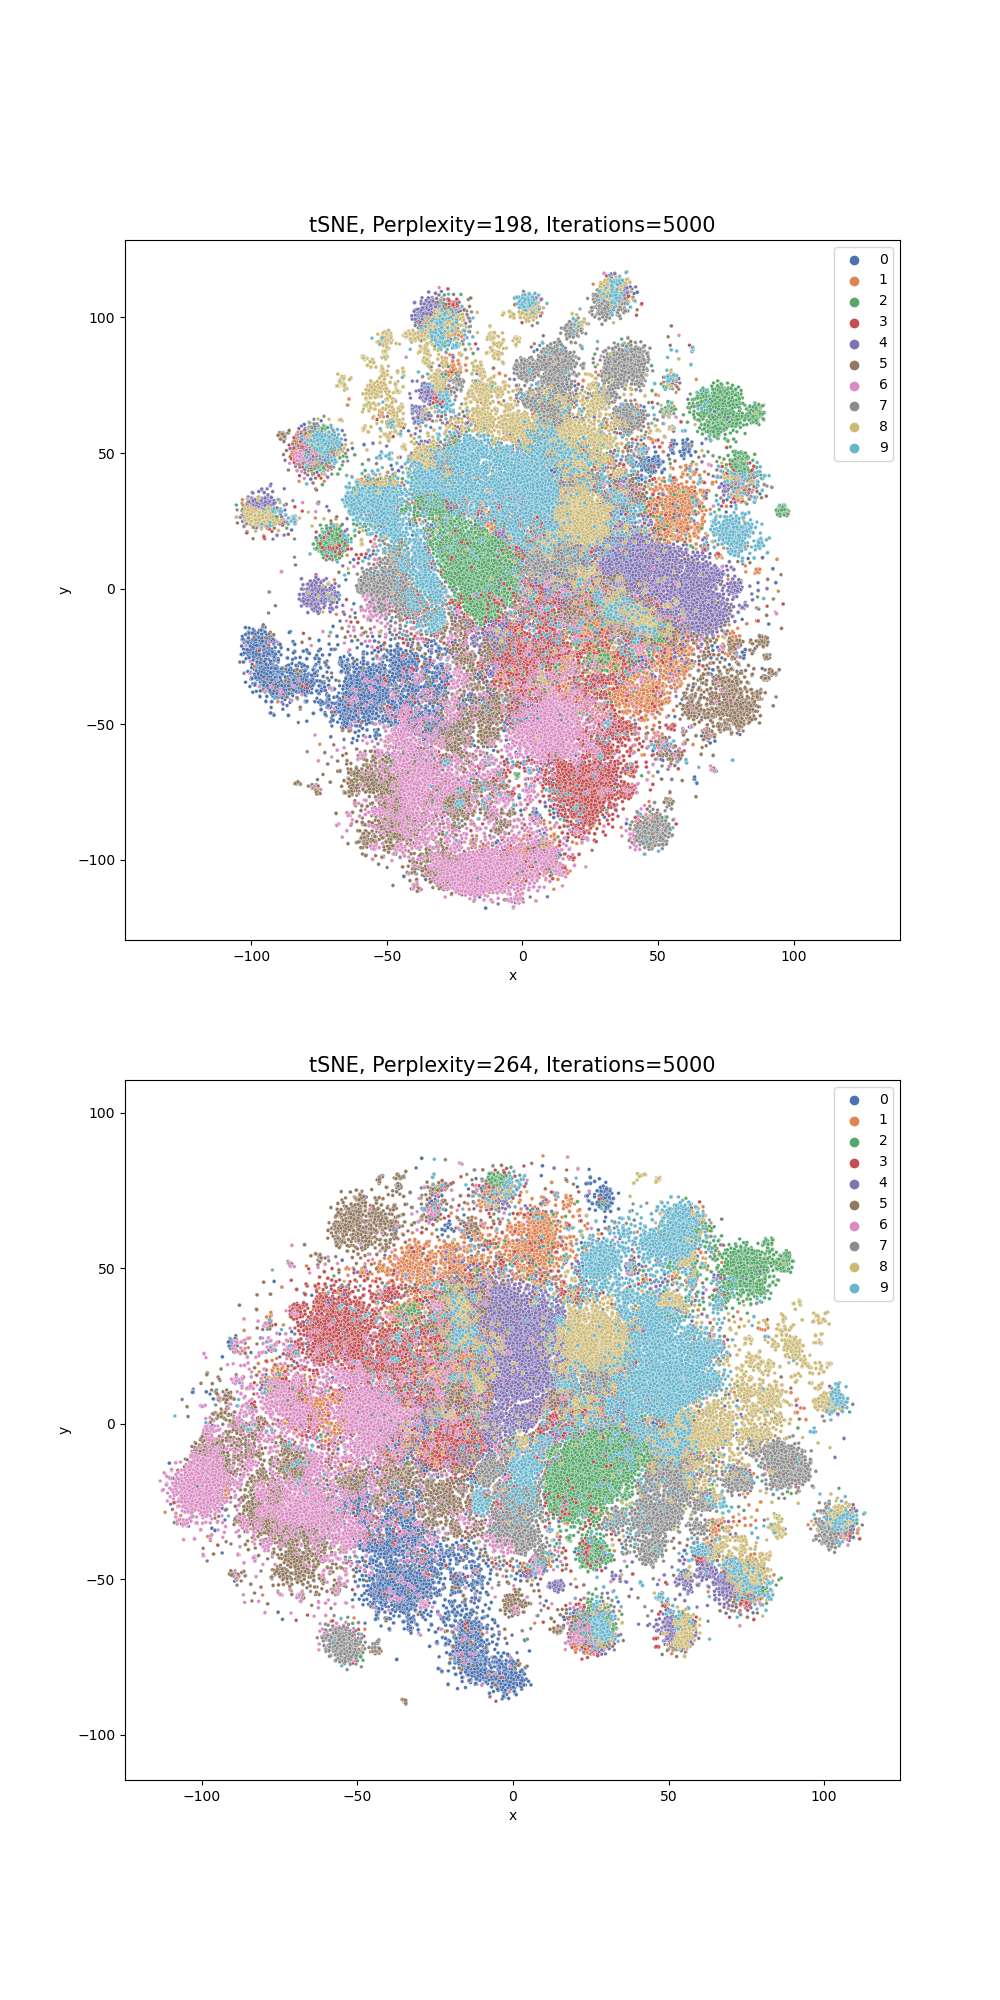

In [33]:
visualize_tsne_embeddings(tsne_embeddings)

### Visualizing other (older) embeddings

# Performing UMAP

In [ ]:
do_umap = True

# UMAP hyperparameters
umap_hyperparams = {
    'n_components_range': [2],
    'n_neighbors_range': [200], #[10, 15, 30, 50, 100, 150, 200],
    'n_epochs_range': [500],
    'min_dist_range': [0.30],#, 0.20],#, 0.30], #[0.05, 0.10, 0.15, 0.20],
    'densmap_range': [False],
    'random_state': [0]
}

if do_umap:
    return_result = True
    save_to_disk = True

    umap_reducer = UMAPReducer(n_components=umap_hyperparams['n_components_range'][0],
                               data=standardized_embeddings,
                               random_state=umap_hyperparams['random_state'][0],
                               n_jobs=-1,
                               hdf_compression='gzip',
                               hdf_compression_lvl=4,
                               return_result=return_result,
                               save_to_disk=save_to_disk,
                               embeddings_round_upto=4,
                               file_args=file_args)

    umap_trial_idx, umap_embeddings, umap_local_radii = umap_reducer.fit_umap(
        n_neighbors_range=umap_hyperparams['n_neighbors_range'],
        n_epochs_range=umap_hyperparams['n_epochs_range'],
        min_dist_range=umap_hyperparams['min_dist_range'],
        densmap_range=umap_hyperparams['densmap_range']
    )
    
# OR, load pre-saved UMAP embeddings from disk (for downstream visualization)
else:
    umap_trial_idx = []
    umap_embeddings = []
    umap_datapath = os.path.join(project_root, 'src', 'data', 'SidBERT_data', 'umap_embeddings')
    for n_nbr in umap_hyperparams['n_neighbors_range']:
        for n_ep in umap_hyperparams['n_epochs_range']:
            for dist in umap_hyperparams['min_dist_range']:
                for densmap in umap_hyperparams['densmap_range']:
                    umap_filename = 'layer{}_Classes{}_SamplesPerRootClass{}_Neighbors{}_Epochs{}_MinDist{}_densmap{}'.format(
                        layer,
                        ''.join(classes_to_visualize),
                        n_samples,
                        n_nbr,
                        n_ep,
                        dist,
                        densmap)
                    dataset_name = 'neighbors={}, epochs={}, min_dist={}, densmap={}'.format(n_nbr, n_ep, dist, densmap)
                    umap_trial_idx.append(dataset_name)
                    with h5py.File(os.path.join(umap_datapath, umap_filename+'.hdf5'), 'r') as f:
                        umap_embeddings.append(np.array(f[dataset_name]))
                
    umap_embeddings = np.array(umap_embeddings)


2022-02-18 19:21:03,124 - root : INFO :- Trial=1--Neighbors=200, Epochs=500, min_dist=0.3, densmap=False


In [25]:
print(umap_trial_idx)
print(np.shape(umap_embeddings))

['neighbors=200, epochs=500, min_dist=0.1, densmap=False', 'neighbors=200, epochs=500, min_dist=0.2, densmap=False']
(2, 70000, 2)


### Visualizing

In [27]:
def visualize_umap_embeddings(list_emb=None):
    
    title_ = 'UMAP, Neighbors={}, Epochs={}, Min_dist={}, Densmap={}'
    dict_color_to_classes = dict(zip(classes_to_visualize, np.arange(0,len(classes_to_visualize))))
    
    nrows = len(umap_hyperparams['n_neighbors_range'])*len(umap_hyperparams['densmap_range'])
    ncols = len(umap_hyperparams['min_dist_range'])
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False,
                             figsize=(ncols*10, nrows*10)
                            )
    subplot_idx=1
    for i in range(nrows):
        nbr_idx = i%len(umap_hyperparams['n_neighbors_range'])
        dens_idx = i//len(umap_hyperparams['n_neighbors_range'])
        for j in range(ncols):
            plt.subplot(nrows,ncols,subplot_idx)
#             if i < len(umap_hyperparams['n_neighbors_range']):
#                 df = pd.DataFrame(list_emb[2*ncols*nbr_idx + 2*j], columns=['x', 'y'])
#             else:
#                 df = pd.DataFrame(list_emb[2*ncols*nbr_idx + 2*j + 1], columns=['x', 'y'])
            
            df = pd.DataFrame(list_emb[ncols*i + j], columns=['x', 'y'])
                
            df['hue'] = pd.Series(np.sort(classes_to_visualize*n_samples))
            sns.scatterplot(x=df['x'],
                            y=df['y'],
                            hue=df['hue'],
                            palette='deep',
                            s=5)
            plt.title(title_.format(umap_hyperparams['n_neighbors_range'][nbr_idx], 
                                    umap_hyperparams['n_epochs_range'][0],
                                    umap_hyperparams['min_dist_range'][j],
                                    umap_hyperparams['densmap_range'][dens_idx]), 
                      fontsize=10)
            plt.gca().set_aspect('equal', 'datalim')
            plt.legend()
            subplot_idx += 1
    plt.show()

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


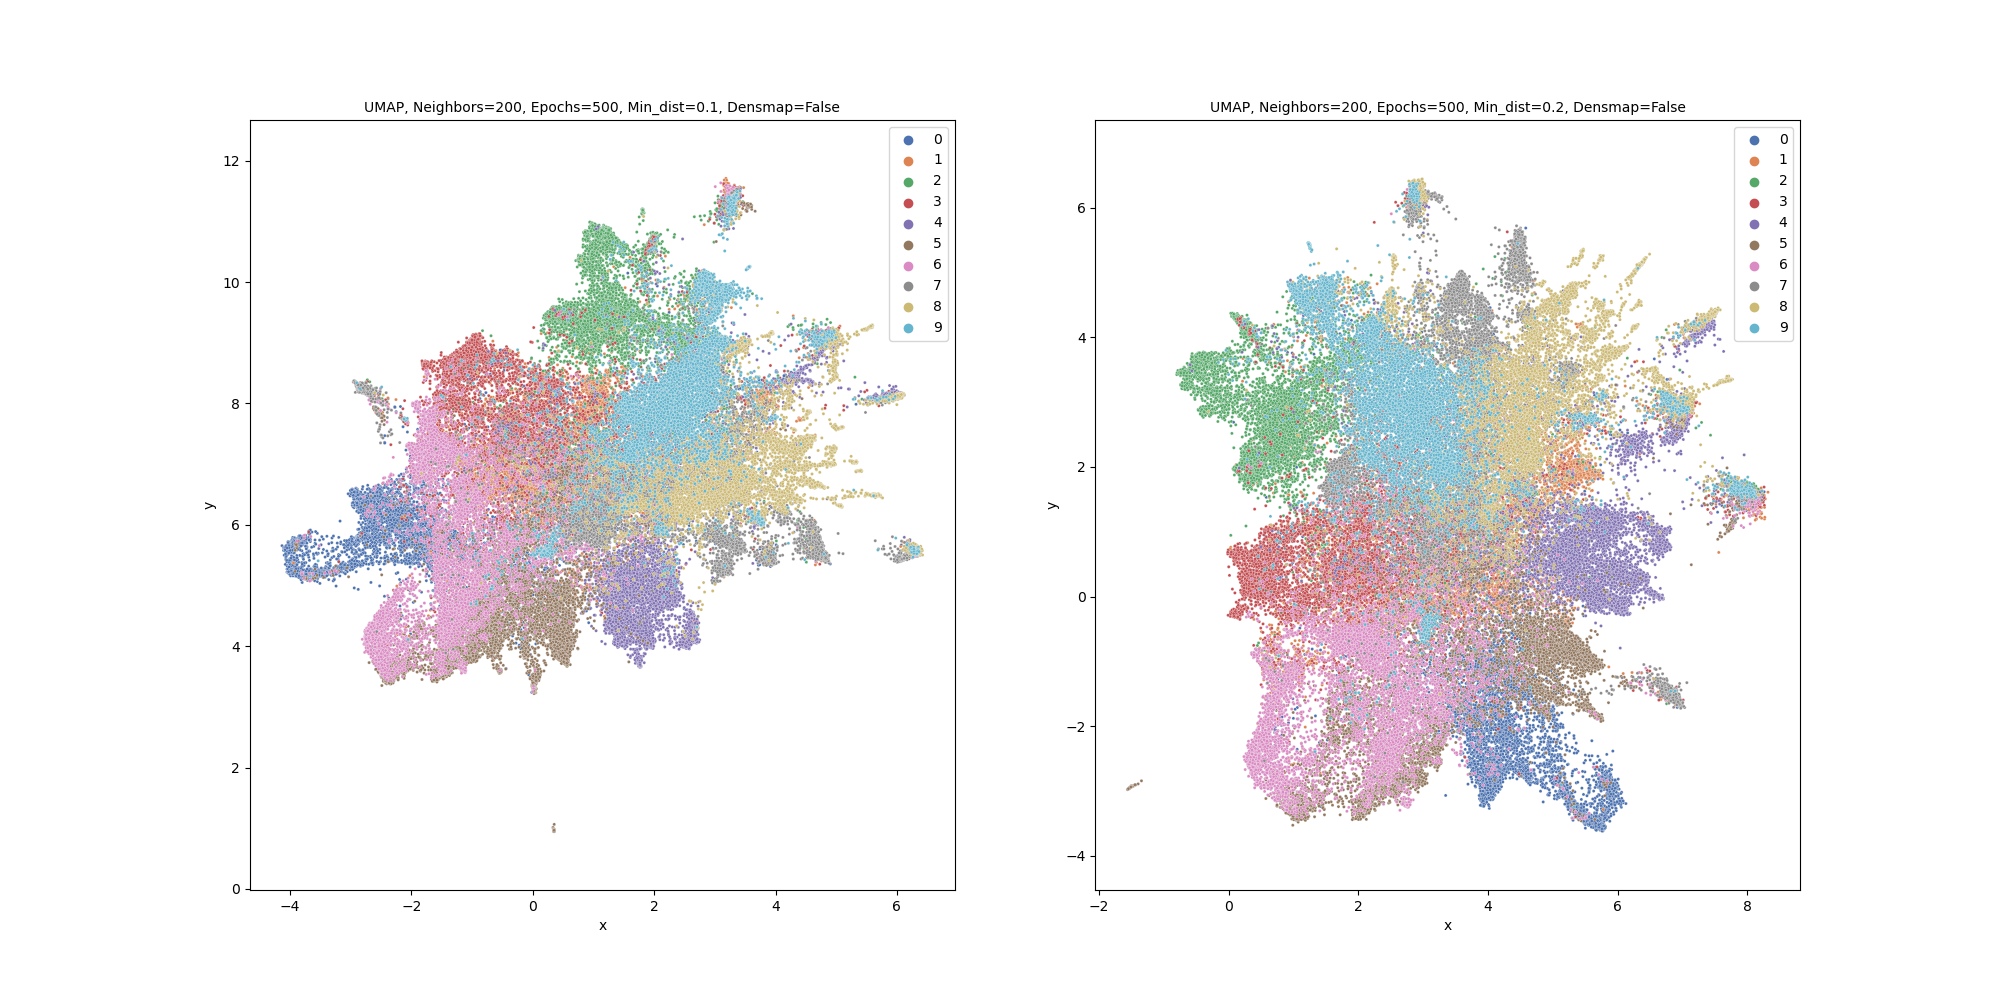

In [28]:
visualize_umap_embeddings(umap_embeddings)